# Test Example

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rcParams['figure.figsize'] = [10, 10]
import torch
import gpytorch


In [2]:
#define GP modified from gpytorch example

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x=self.covar_module(x);
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [3]:
# set training data
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

#kernel model
K1=gpytorch.kernels.AdditiveKernel(gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())+gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()))


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood,K1)


#get number of parameters to optimize
for i in list(model.named_parameters()):
    print(i)
print("\n")


number=0
for i in list(model.parameters()):
    if i.requires_grad:
        a=np.array([],dtype=np.int32);
        for j in range(len(i.size())):
            a=np.hstack((a,i.size(j)));
        print(i,"has size",a, "shape tensor",a.shape,"the sum",a.sum(axis=0),"the product",a.prod(axis=0))
        number+=a.prod(axis=0);
        print("number of parameters ...",number)
print("number of parameters",number)



('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.kernels.0.kernels.0.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.kernels.0.kernels.0.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))
('covar_module.kernels.0.kernels.1.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.kernels.0.kernels.1.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))


Parameter containing:
tensor([0.], requires_grad=True) has size [1] shape tensor (1,) the sum 1 the product 1
number of parameters ... 1
Parameter containing:
tensor([0.], requires_grad=True) has size [1] shape tensor (1,) the sum 1 the product 1
number of parameters ... 2
Parameter containing:
tensor(0., requires_grad=True) has size [] shape tensor (0,) the sum

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)+0.5*number*np.log(train_x.size(0))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 14.714   noise: 0.693
Iter 2/100 - Loss: 14.676   noise: 0.644
Iter 3/100 - Loss: 14.636   noise: 0.598
Iter 4/100 - Loss: 14.595   noise: 0.554
Iter 5/100 - Loss: 14.553   noise: 0.513
Iter 6/100 - Loss: 14.513   noise: 0.474
Iter 7/100 - Loss: 14.474   noise: 0.437
Iter 8/100 - Loss: 14.437   noise: 0.402
Iter 9/100 - Loss: 14.400   noise: 0.370
Iter 10/100 - Loss: 14.365   noise: 0.340
Iter 11/100 - Loss: 14.331   noise: 0.311
Iter 12/100 - Loss: 14.296   noise: 0.285
Iter 13/100 - Loss: 14.262   noise: 0.261
Iter 14/100 - Loss: 14.227   noise: 0.239
Iter 15/100 - Loss: 14.192   noise: 0.218
Iter 16/100 - Loss: 14.157   noise: 0.199
Iter 17/100 - Loss: 14.122   noise: 0.181
Iter 18/100 - Loss: 14.088   noise: 0.165
Iter 19/100 - Loss: 14.054   noise: 0.151
Iter 20/100 - Loss: 14.021   noise: 0.137
Iter 21/100 - Loss: 13.990   noise: 0.125
Iter 22/100 - Loss: 13.960   noise: 0.114
Iter 23/100 - Loss: 13.932   noise: 0.104
Iter 24/100 - Loss: 13.906   noise: 0.095
I

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
#with torch.no_grad(), gpytorch.settings.fast_pred_var():
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

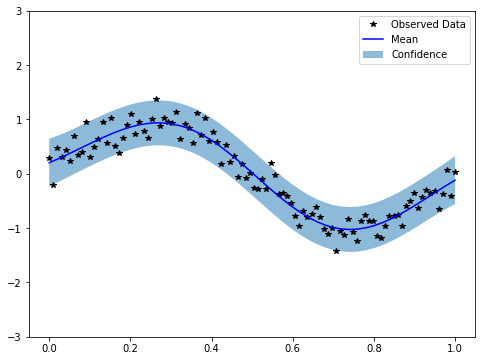

In [7]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])